In [1]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import rmgpy.constants
import adsorbate_thermo
import rmgpy.species

In [2]:
gas1 = ct.Solution('ptcombust.cti')
surf1 = ct.Interface('ptcombust.cti', 'Pt_surf', [gas1])

In [3]:
surf1.species()

[<Species PT(S)>,
 <Species H(S)>,
 <Species H2O(S)>,
 <Species OH(S)>,
 <Species CO(S)>,
 <Species CO2(S)>,
 <Species CH3(S)>,
 <Species CH2(S)s>,
 <Species CH(S)>,
 <Species C(S)>,
 <Species O(S)>]

In [4]:
gas1.TPX = 300, 101325, {'H2O': 1.0}

In [5]:
# surf1.TPX = 300, 101325, {'H2O(S)': 0.1, 'PT(S)': 0.9}
surf1.TPX = 300, 101325, {'H2O(S)': 1.0}

In [6]:
surf1.species()[2].thermo.coeffs
midpoint = surf1.species()[2].thermo.coeffs[0]
a_high = surf1.species()[2].thermo.coeffs[1:8]
a_low = surf1.species()[2].thermo.coeffs[8:]

In [7]:
len(a_high)

7

In [8]:
len(a_low)

7

In [9]:
def get_thermo_from_NASA2(temperatures, a_low, a_high):
    # compute thermo properties from nasa polynomials
    T_switch = 1000.0
    R = rmgpy.constants.R
    i_switch = -1
    for i in range(len(temperatures)):
        if temperatures[i] == T_switch:
            i_switch = i

    cp_fit = np.zeros(len(temperatures))
    h_fit = np.zeros(len(temperatures))
    s_fit = np.zeros(len(temperatures))
    for (i, temp) in enumerate(temperatures):
        if temp <= T_switch:
            cp_fit[i] = a_low[0] + a_low[1] * temp + a_low[2] * temp**2.0 + a_low[3] * temp**3.0 + a_low[4] * temp**4.0
            h_fit[i] = a_low[0] * temp + a_low[1] / 2.0 * temp**2.0 + a_low[2] / 3.0 * temp**3.0 + a_low[3] / 4.0 * temp**4.0 + a_low[4] / 5.0 * temp**5.0 + a_low[5]
            s_fit[i] = a_low[0] * np.log(temp) + a_low[1] * temp + a_low[2] / 2.0 * temp**2.0 + a_low[3] / 3.0 * temp**3.0 + a_low[4] / 4.0 * temp**4.0 + a_low[6]
        else:
            cp_fit[i] = a_high[0] + a_high[1] * temp + a_high[2] * temp**2.0 + a_high[3] * temp**3.0 + a_high[4] * temp**4.0
            h_fit[i] = a_high[0] * temp + a_high[1] / 2.0 * temp**2.0 + a_high[2] / 3.0 * temp**3.0 + a_high[3] / 4.0 * temp**4.0 + a_high[4] / 5.0 * temp**5.0 + a_high[5]
            s_fit[i] = a_high[0] * np.log(temp) + a_high[1] * temp + a_high[2] / 2.0 * temp**2.0 + a_high[3] / 3.0 * temp**3.0 + a_high[4] / 4.0 * temp**4.0 + a_high[6]

    cp_fit *= R
    h_fit *= R
    s_fit *= R

    return cp_fit, h_fit, s_fit


In [10]:
molecular_weight = 18.02
frequencies = [49.5, 68.6, 73.6, 102.0, 437.6, 452.9, 1596.3, 3675.6, 3787.0]
composition = {'H': 2, 'O': 1, 'C': 0, 'N': 0}
heat_of_formation_0K = -259.05  # kJ/mol
my_calc = adsorbate_thermo.AdsorbateThermoCalc(molecular_weight, frequencies, composition, heat_of_formation_0K, twoD_gas=True)
a_low2, a_high2 = my_calc.get_thermo2()

/home/moon/rmg/rmg_tools/adsorbate_thermo/adsorbate_thermo.py:232: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a_low = np.linalg.lstsq(Y, b)[0]
/home/moon/rmg/rmg_tools/adsorbate_thermo/adsorbate_thermo.py:257: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a_high = np.append(a_high, np.linalg.lstsq(Y, b)[0])


In [11]:
temperatures = np.linspace(300, 2000, 201)
cp_fit, h_fit, s_fit = get_thermo_from_NASA2(temperatures, a_low, a_high)
cp_fit2, h_fit2, s_fit2 = my_calc.get_thermo_from_NASA2(a_low, a_high)

In [12]:
dir(surf1)

['DP',
 'DPX',
 'DPY',
 'HP',
 'HPX',
 'HPY',
 'ID',
 'P',
 'P_sat',
 'SP',
 'SPX',
 'SPY',
 'SV',
 'SVX',
 'SVY',
 'T',
 'TD',
 'TDX',
 'TDY',
 'TP',
 'TPX',
 'TPY',
 'T_sat',
 'UV',
 'UVX',
 'UVY',
 'X',
 'Y',
 '__call__',
 '__class__',
 '__composition_to_array',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_check_kinetics_species_index',
 '_check_phase_index',
 '_check_reaction_index',
 '_full_states',
 '_init_cti_xml',
 '_init_parts',
 '_init_yaml',
 '_native_state',
 '_partial_states',
 '_phase_indices',
 '_phase_slice',
 '_references',
 'activities',
 'activity_coefficients',
 'add_reaction',
 'add_species',
 'add_species_alias',
 'advance_

In [13]:
H_3 = np.zeros(len(temperatures))
Cp_3 = np.zeros(len(temperatures))
S_3 = np.zeros(len(temperatures))
for i, T in enumerate(temperatures):
    surf1.TPX = T, 101325, {'H2O(S)': 1.0}
    Cp_3[i] = surf1.cp_mole/1000.0
    H_3[i] = surf1.enthalpy_mole/1000.0
    S_3[i] = surf1.entropy_mole/1000.0

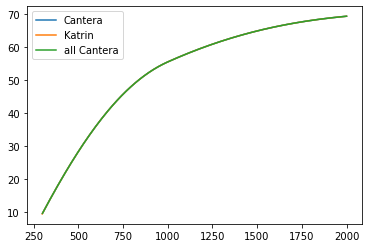

In [14]:
plt.plot(temperatures, cp_fit)
plt.plot(my_calc.temperatures, cp_fit2)
plt.plot(temperatures, Cp_3)
plt.legend(['Cantera', 'Katrin', 'all Cantera'])

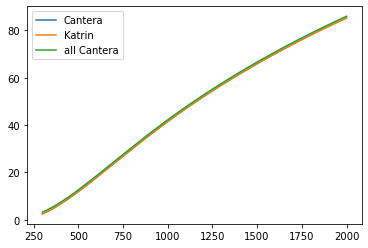

In [15]:
plt.plot(temperatures, s_fit)
plt.plot(my_calc.temperatures, s_fit2)
plt.plot(temperatures, S_3)
plt.legend(['Cantera', 'Katrin', 'all Cantera'])

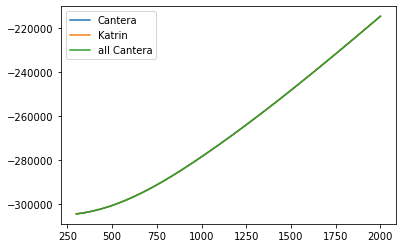

In [16]:
plt.plot(temperatures, h_fit)
plt.plot(my_calc.temperatures, h_fit2)
plt.plot(temperatures, H_3)
plt.legend(['Cantera', 'Katrin', 'all Cantera'])

In [26]:
sp1 = rmgpy.species.Species(smiles='O')
thermo = sp1.get_thermo_data()

AttributeError: 'NoneType' object has no attribute 'result'

In [23]:
dir(sp1)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_molecular_weight',
 '_repr_png_',
 'aug_inchi',
 'calculate_cp0',
 'calculate_cpinf',
 'conformer',
 'contains_surface_site',
 'copy',
 'creation_iteration',
 'energy_transfer_model',
 'explicitly_allowed',
 'fingerprint',
 'from_adjacency_list',
 'from_smiles',
 'generate_aug_inchi',
 'generate_energy_transfer_model',
 'generate_resonance_structures',
 'generate_statmech',
 'generate_transport_data',
 'get_augmented_inchi',
 'get_density_of_states',
 'get_enthalpy',
 'get_entropy',
 'get_free_energy',
 'get_heat_capacity',
 'get_partition_function',
 'get_resonance_hybrid',
 'get_sum_of_states',
 'get_symmetry_number',
 'get_thermo_data',
 'ge